# RETRIEVAL Step from RAG

### Loading Libraries

In [137]:
import pandas as pd
import time

from datasets import Dataset

from langchain_ollama import ChatOllama, OllamaEmbeddings

from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy
)
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.run_config import RunConfig



## Step 1 : Data Collection
Note  : Data has already been cleaned, none answers are removed

In [138]:
#Run this below code only once to download the dataset
#!pip install --quiet gdown
#file_id = "1-jDEeu3yu-UvUGEsBqxzBHfBWBRLG5c7"
#!gdown --id $file_id

df_original = pd.read_csv("MedQuAD_combined.csv") #df_original = pd.read_csv("./content/MedQuAD_combined.csv") 
df_original.head(5)

,document_id,url,source_file,folder_name,focus,umls_cuis,qapair_pid,question_qid,question_qtype,question,answer,source_csv
0,5989,https://rarediseases.info.nih.gov/gard/10547/syringoma,0005989.xml,2_GARD_QA,Syringoma,C0206673,1,0005989-1,information,What is (are) Syringoma ?,"Syringomas are firm yellowish, translucent, or skin colored papules that are often found on the face, particularly around the eyes. They may occur suddenly in crops or multiples. They arise from the sweat ducts. They usually cause no symptoms. They are not associated with underlying abnormality. They are found more commonly in Caucasians, and in females at puberty or near middle-age.",2_GARD_QA.csv
1,5989,https://rarediseases.info.nih.gov/gard/10547/syringoma,0005989.xml,2_GARD_QA,Syringoma,C0206673,2,0005989-2,symptoms,What are the symptoms of Syringoma ?,"What are the signs and symptoms of Syringoma? The Human Phenotype Ontology provides the following list of signs and symptoms for Syringoma. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the skin - Autosomal dominant inheritance - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate of the percentage of patients who have that feature. The frequency may also be listed as a fraction. The first number of the fraction is how many people had the symptom, and the second number is the total number of people who were examined in one study. For example, a frequency of 25/25 means that in a study of 25 people all patients were found to have that symptom. Because these frequencies are based on a specific study, the fractions may be different if another group of patients are examined. Sometimes, no information on frequency is available. In these cases, the sign or symptom may be rare or common.",2_GARD_QA.csv
2,5989,https://rarediseases.info.nih.gov/gard/10547/syringoma,0005989.xml,2_GARD_QA,Syringoma,C0206673,3,0005989-3,treatment,What are the treatments for Syringoma ?,"How are syringomas treated? People with syringomas have a variety of treatment options, for example pulsed ablative laser (CO2 or erbium) or light electrocoagulation using a fine epilating needle. To learn more about these and other syringoma treatment options we recommend speaking with your healthcare provider.",2_GARD_QA.csv
3,1529,https://rarediseases.info.nih.gov/gard/2104/congenital-lobar-emphysema,0001529.xml,2_GARD_QA,Congenital lobar emphysema,C0265797,1,0001529-1,information,What is (are) Congenital lobar emphysema ?,"Congenital lobar emphysema is a rare respiratory disorder in which air can enter the lungs but cannot escape, causing overinflation (hyperinflation) of the lobes of the lung. It is most often detected in newborns or young infants, but some cases do not become apparent until adulthood. Signs and symptoms may include difficulty breathing and respiratory distress in infancy, an enlarged chest, compressed lung tissue, cyanosis, and underdevelopment of the cartilage that supports the bronchial tube (bronchial hypoplasia). This disorder may be severe enough to cause associated heart problems (15% of cases) or so mild as to never become apparent. Some cases may be caused by autosomal dominant inheritance while others occur for no apparent reason (sporadic).",2_GARD_QA.csv
4,1529,https://rarediseases.info.nih.gov/gard/2104/congenital-lobar-emphysema,0001529.xml,2_GARD_QA,Congenital lobar emphysema,C0265797,2,0001529-2,symptoms,What are the symptoms of Congenital lobar emphysema ?,"What are the signs and symptoms of Congenital lobar emphysema? The Human Phenotype Ontology p

In [139]:
df_original.columns

Index(['document_id', 'url', 'source_file', 'folder_name', 'focus',
       'umls_cuis', 'qapair_pid', 'question_qid', 'question_qtype', 'question',
       'answer', 'source_csv'],
      dtype='object')

In [140]:
print(f"Total Questions {df_original['source_csv'].size}")

Total Questions 16407


## Data Filtering

In [141]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
df_8 = df_original[df_original['folder_name'] == '8_NHLBI_QA_XML']
#df_8.head(2)

In [142]:
df_8['focus'].value_counts()

focus
Overweight and Obesity                    8
Diabetic Heart Disease                    7
Cardiogenic Shock                         7
Vasculitis                                7
Fanconi Anemia                            7
Rh Incompatibility                        7
Deep Vein Thrombosis                      7
Polycythemia Vera                         7
Iron-Deficiency Anemia                    7
Coronary Heart Disease                    7
Thrombocytopenia                          7
Atherosclerosis                           7
Pulmonary Embolism                        7
Mitral Valve Prolapse                     7
Bronchiectasis                            7
High Blood Pressure                       7
Hemolytic Anemia                          7
Heart Valve Disease                       7
Carotid Artery Disease                    7
Angina                                    7
Sudden Cardiac Arrest                     7
Sickle Cell Disease                       7
Pericarditis              

In [143]:
focus_counts = df_8['focus'].value_counts()
print(f"Total number of unique focus areas: {len(focus_counts)}")
print(f"Total count of all records: {focus_counts.sum()}")
print(f"\nBreakdown by focus area:\n{focus_counts}")


Total number of unique focus areas: 88
Total count of all records: 559

Breakdown by focus area:
focus
Overweight and Obesity                    8
Diabetic Heart Disease                    7
Cardiogenic Shock                         7
Vasculitis                                7
Fanconi Anemia                            7
Rh Incompatibility                        7
Deep Vein Thrombosis                      7
Polycythemia Vera                         7
Iron-Deficiency Anemia                    7
Coronary Heart Disease                    7
Thrombocytopenia                          7
Atherosclerosis                           7
Pulmonary Embolism                        7
Mitral Valve Prolapse                     7
Bronchiectasis                            7
High Blood Pressure                       7
Hemolytic Anemia                          7
Heart Valve Disease                       7
Carotid Artery Disease                    7
Angina                                    7
Sudden Cardiac Ar

In [144]:
question_type_counts = df_8['question_qtype'].value_counts()
print(f"Total number of unique focus areas: {len(question_type_counts)}")
print(f"Total count of all records: {question_type_counts.sum()}")
print(f"\nBreakdown by focus area:\n{question_type_counts}")




Total number of unique focus areas: 8
Total count of all records: 559

Breakdown by focus area:
question_qtype
information        86
symptoms           84
causes             83
exams and tests    83
treatment          83
susceptibility     80
prevention         55
outlook             5
Name: count, dtype: int64


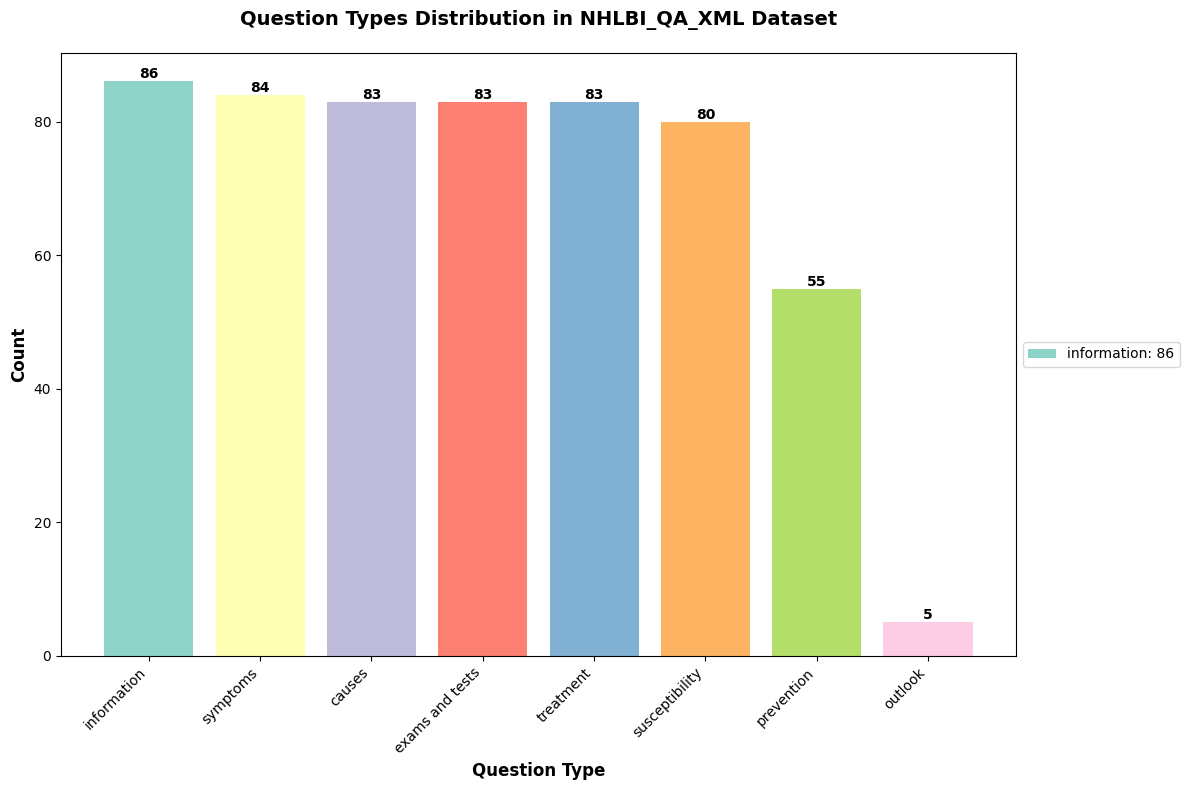


--- Question Type Summary ---
Total question types: 8
Total questions: 559

Detailed Breakdown:
  information: 86 (15.4%)
  symptoms: 84 (15.0%)
  causes: 83 (14.8%)
  exams and tests: 83 (14.8%)
  treatment: 83 (14.8%)
  susceptibility: 80 (14.3%)
  prevention: 55 (9.8%)
  outlook: 5 (0.9%)


In [205]:
# Beautified bar chart with summary statistics
fig, ax = plt.subplots(figsize=(12, 8))

question_type_counts = df_8['question_qtype'].value_counts()

# Create bar chart with enhanced styling
colors = plt.cm.Set3(range(len(question_type_counts)))
bars = ax.bar(question_type_counts.index, question_type_counts.values, color=colors)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add title and labels
ax.set_title('Question Types Distribution in NHLBI_QA_XML Dataset', 
             fontsize=14, fontweight='bold', pad=20, color='black')
ax.set_xlabel('Question Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Enhance percentage text
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

# Add title and labels
ax.set_title('Question Types Distribution in NHLBI_QA_XML Dataset', 
             fontsize=14, fontweight='bold', pad=20, color='black')

# Add legend with counts
legend_labels = [f'{qtype}: {count}' for qtype, count in question_type_counts.items()]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n--- Question Type Summary ---")
print(f"Total question types: {len(question_type_counts)}")
print(f"Total questions: {question_type_counts.sum()}")
print(f"\nDetailed Breakdown:")
for qtype, count in question_type_counts.items():
    percentage = (count / question_type_counts.sum()) * 100
    print(f"  {qtype}: {count} ({percentage:.1f}%)")


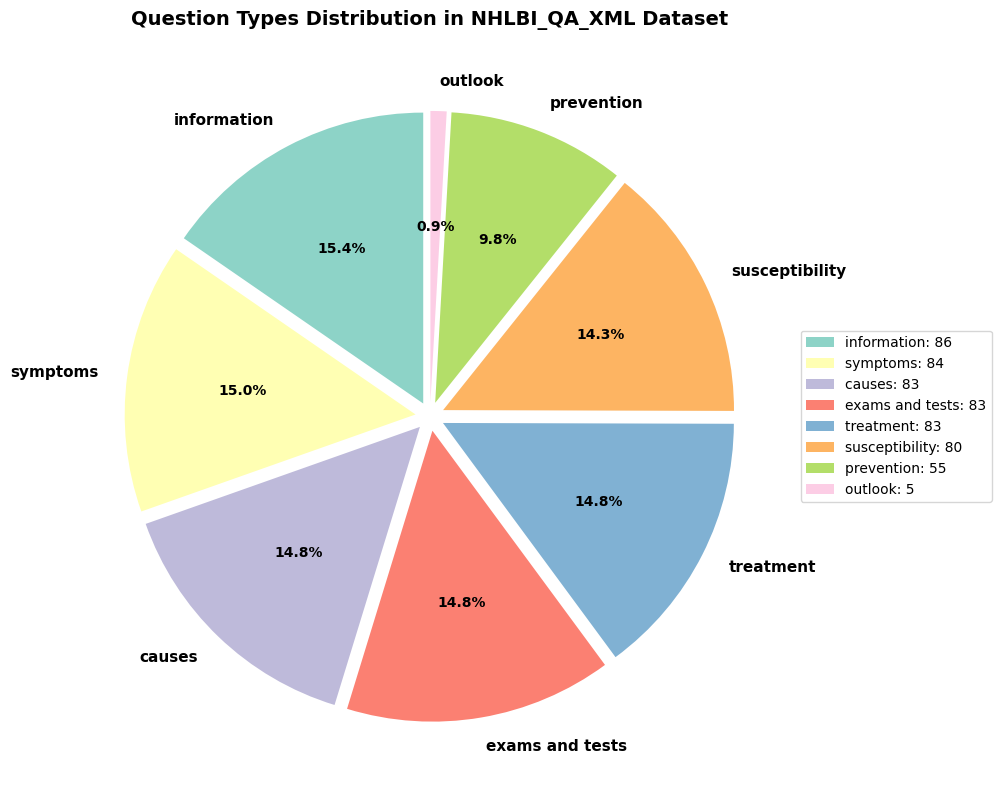


--- Question Type Summary ---
Total question types: 8
Total questions: 559

Detailed Breakdown:
  information: 86 (15.4%)
  symptoms: 84 (15.0%)
  causes: 83 (14.8%)
  exams and tests: 83 (14.8%)
  treatment: 83 (14.8%)
  susceptibility: 80 (14.3%)
  prevention: 55 (9.8%)
  outlook: 5 (0.9%)


In [145]:
# Beautified pie chart with summary statistics
fig, ax = plt.subplots(figsize=(12, 8))

question_type_counts = df_8['question_qtype'].value_counts()

# Create pie chart with enhanced styling
colors = plt.cm.Set3(range(len(question_type_counts)))
wedges, texts, autotexts = ax.pie(
    question_type_counts.values,
    labels=question_type_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11, 'weight': 'bold', 'color': 'black'},
    explode=[0.05] * len(question_type_counts)  # Slightly separate slices
)

# Enhance percentage text
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

# Add title and labels
ax.set_title('Question Types Distribution in NHLBI_QA_XML Dataset', 
             fontsize=14, fontweight='bold', pad=20, color='black')

# Add legend with counts
legend_labels = [f'{qtype}: {count}' for qtype, count in question_type_counts.items()]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n--- Question Type Summary ---")
print(f"Total question types: {len(question_type_counts)}")
print(f"Total questions: {question_type_counts.sum()}")
print(f"\nDetailed Breakdown:")
for qtype, count in question_type_counts.items():
    percentage = (count / question_type_counts.sum()) * 100
    print(f"  {qtype}: {count} ({percentage:.1f}%)")


In [146]:
df_8['answer'] = (
    df_8['answer']
    .astype(str)
    .str.replace('\n', ' ', regex=False)
    .str.replace('  +', ' ', regex=True)
    .str.strip()
)

/var/folders/xp/h8tpxl79665f31jthw8rnl700000gn/T/ipykernel_19437/682933180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8['answer'] = (


In [147]:
df_8[(df_8['focus'] == 'Asthma') & (df_8['folder_name'] == '8_NHLBI_QA_XML')].columns

Index(['document_id', 'url', 'source_file', 'folder_name', 'focus',
       'umls_cuis', 'qapair_pid', 'question_qid', 'question_qtype', 'question',
       'answer', 'source_csv'],
      dtype='object')

<h2>Chunking</h2>

In [148]:
df_8['text'] = (
    "Focus Area: " + df_8['focus'].fillna('') +
    " ; Question: " + df_8['question'].fillna('') +
    " ; Question Type: " + df_8['question_qtype'].fillna('') +
    " ; Source: " + df_8['url'].fillna('') +
    " ; Answer: " + df_8['answer'].fillna('')
)

/var/folders/xp/h8tpxl79665f31jthw8rnl700000gn/T/ipykernel_19437/3620440325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8['text'] = (


In [149]:
df_8[(df_8['focus'] == 'Asthma') & (df_8['folder_name'] == '8_NHLBI_QA_XML')]['text'].head(1)

5431    Focus Area: Asthma ; Question: What is (are) Asthma ? ; Question Type: information ; Source: http://www.nhlbi.nih.gov/health/health-topics/topics/asthma ; Answer: Espaol Asthma (AZ-ma) is a chronic (long-term) lung disease that inflames and narrows the airways. Asthma causes recurring periods of wheezing (a whistling sound when you breathe), chest tightness, shortness of breath, and coughing. The coughing often occurs at night or early in the morning. Asthma affects people of all ages, but it most often starts during childhood. In the United States, more than 25 million people are known to have asthma. About 7million of these people are children. Overview To understand asthma, it helps to know how the airways work. The airways are tubes that carry air into and out of your lungs. People who have asthma have inflamed airways. The inflammation makes the airways swollen and very sensitive. The airways tend to react strongly to certain inhaled substances. When the airways react, the

### Tokenization

In [150]:
# --- Load model with a clear log (avoid silent hanging) ---
print("Loading E5 model...")
model = SentenceTransformer("intfloat/e5-base")
print("Model loaded!")

Loading E5 model...
Model loaded!
Model loaded!


<h2>Embedding</h2>

In [151]:
def embed_in_batches(texts, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        emb = model.encode(
            batch,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        embeddings.append(emb)
    return np.vstack(embeddings).astype("float32")

In [152]:
# --- Generate embeddings ---
print("Encoding text...")
embeddings_8 = embed_in_batches(df_8['text'].tolist(), batch_size=16)

Encoding text...


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:52<00:00,  1.51s/it]


In [153]:
print("Embedding complete!")
print("Shape:", embeddings_8.shape)
print(f"Print Embedding : \n\n{embeddings_8}")


Embedding complete!
Shape: (559, 768)
Print Embedding : 

[[-0.01371174 -0.00711623  0.00572891 ...  0.05960369 -0.00908278
   0.04892368]
 [-0.00195517  0.0215183   0.01383722 ...  0.03113322 -0.0176784
   0.04428563]
 [-0.00476019  0.015416   -0.02438999 ...  0.03812213 -0.00251934
   0.03905122]
 ...
 [-0.01077897  0.01866283  0.00293324 ...  0.05316177 -0.00267748
   0.03752558]
 [-0.02437314  0.01621316 -0.00270394 ...  0.02732627 -0.00694504
   0.01878359]
 [-0.01738711  0.01428856 -0.00088273 ...  0.0508728   0.01831759
   0.04590632]]


In [154]:
dimension = embeddings_8.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings_8)
#index
print("Total vectors in FAISS:", index.ntotal)
print("Dimensionality of Vectors:", index.d)

Total vectors in FAISS: 559
Dimensionality of Vectors: 768


<h2>Retrieval</h2>

In [155]:
def retrieve(query, k=3, threshold=0.50):
    query_emb = model.encode(
        ["query: " + query],
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    D, I = index.search(query_emb.astype('float32'), k)

    sims = cosine_similarity(query_emb, embeddings_8)[0]
    top_idx = sims.argsort()[::-1][:k]

    best_score = sims[top_idx[0]]

    # If nothing relevant → return None
    if best_score < threshold:
        return None, best_score

    results = []
    for idx in top_idx:
        results.append({
            "rank": len(results)+1,
            "score": float(sims[idx]),
            "focus": df_8.iloc[idx]['focus'],
            "question": df_8.iloc[idx]['question'],
            "url" : df_8.iloc[idx]['url'],
            "answer": df_8.iloc[idx]['answer'].strip(),
            "text": df_8.iloc[idx]['text']
        })
    return results, best_score

In [156]:
def print_retrieval_results(results):
    if results is None:
        print("No relevant documents found.")
        return
    for res in results:
        print(f"Rank: {res['rank']}")
        print(f"Score: {res['score']:.4f}")
        print(f"Focus: {res['focus']}")
        print(f"Question: {res['question']}")
        print(f"URL: {res['url']}")
        print(f"Answer: {res['answer']}")
        print("-" * 50)

In [157]:
questons = ["What causes anemia?","What causes Macbook's price drop?","How do I know he has asthma?","What is AIDS"]

for q in questons:
    print(f"\n\nQuery: {q}")
    results, best_score = retrieve(q)
    print(f"Best Similarity Score: {best_score:.4f}")
    print_retrieval_results(results)



Query: What causes anemia?
Best Similarity Score: 0.9002
Rank: 1
Score: 0.9002
Focus: Anemia
Question: What causes Anemia ?
URL: http://www.nhlbi.nih.gov/health/health-topics/topics/anemia
Answer: The three main causes of anemia are: Blood loss Lack of red blood cell production High rates of red blood cell destruction For some people, the condition is caused by more than one of these factors. Blood Loss Blood loss is the most common cause of anemia, especially iron-deficiency anemia. Blood loss can be short term or persist over time. Heavy menstrual periods or bleeding in the digestive or urinary tract can cause blood loss. Surgery, trauma, or cancer also can cause blood loss. If a lot of blood is lost, the body may lose enough red blood cells to cause anemia. Lack of Red Blood Cell Production Both acquired and inherited conditions and factors can prevent your body from making enough red blood cells. "Acquired" means you aren't born with the condition, but you develop it. "Inherited"

## Evaluating our Retrieval

1. **Precision** (manual & RAGAs)
2. **Recall** (RAGAs)
3. **MRR** (Mean Reciprocal Rank) (Manual)

<h1>

<h2>Manual Evaluation</h2>

#### Test Questions & Ground Truths

In [158]:
# Define test_questions and ground_truth_answers for this example
test_questions = [
    "What are the symptoms of asthma?",
    "How to fix a broken car engine?",
    "What causes coughing?",
    "Tell me about cars?",
    "Can we cure AIDS?"
]

ground_truth_answers = [
    "asthma",
    "engine",
    "coughing",
    "cars",
    "AIDS"
]

### Manual Precision Evaluation

#### 

In [159]:
def calculate_precision_score(query, ground_truth, k=3):
    # Use the existing retrieve function
    retrieval_output = retrieve(query, k=k)


    retrieved_docs = []
    if isinstance(retrieval_output, tuple):
        # If retrieve returns a tuple (docs, score) or (None, score)
        retrieved_docs, best_score = retrieval_output
        if retrieved_docs is None:
            # No relevant documents found above threshold
            return 0.0
    # If retrieve somehow returns a list directly (though current retrieve returns tuple),
    # this case is implicitly handled if not a tuple. But retrieve currently always returns a tuple.

    if not retrieved_docs:
        return 0.0

    # Extract answers from the list of retrieved document dictionaries
    retrieved_answers = [doc['answer'] for doc in retrieved_docs]

    # Check relevance: 1 if ground_truth is in the retrieved answer, else 0
    relevant = [1 if ground_truth.lower() in txt.lower() else 0 for txt in retrieved_answers]

    # Precision: fraction of retrieved documents that are relevant
    actual_k = len(retrieved_docs)
    precision = sum(relevant) / actual_k if actual_k > 0 else 0.0

    return precision


print("\n--- Precision Score Examples (k=3) ---")
for i, question in enumerate(test_questions):
    ground_truth = ground_truth_answers[i]
    precision = calculate_precision_score(question, ground_truth, k=3)
    print(f"Question: '{question}'\n  Ground Truth: '{ground_truth}'\n  Precision : {precision:.2f}\n")


--- Precision Score Examples (k=3) ---
Question: 'What are the symptoms of asthma?'
  Ground Truth: 'asthma'
  Precision : 1.00

Question: 'How to fix a broken car engine?'
  Ground Truth: 'engine'
  Precision : 0.00

Question: 'What causes coughing?'
  Ground Truth: 'coughing'
  Precision : 1.00

Question: 'What are the symptoms of asthma?'
  Ground Truth: 'asthma'
  Precision : 1.00

Question: 'How to fix a broken car engine?'
  Ground Truth: 'engine'
  Precision : 0.00

Question: 'What causes coughing?'
  Ground Truth: 'coughing'
  Precision : 1.00

Question: 'Tell me about cars?'
  Ground Truth: 'cars'
  Precision : 0.00

Question: 'Can we cure AIDS?'
  Ground Truth: 'AIDS'
  Precision : 0.33

Question: 'Tell me about cars?'
  Ground Truth: 'cars'
  Precision : 0.00

Question: 'Can we cure AIDS?'
  Ground Truth: 'AIDS'
  Precision : 0.33



### Manual MRR (Mean Reciprocal Rank)

In [160]:
def calculate_mrr_score(query, ground_truth, k=3):
    """
    Calculate Mean Reciprocal Rank (MRR).
    MRR measures the rank position of the first relevant document.
    
    Formula: MRR = 1 / rank of first relevant document
    Returns 0 if no relevant document found.
    """
    retrieval_output = retrieve(query, k=k)
    
    if isinstance(retrieval_output, tuple):
        retrieved_docs, best_score = retrieval_output
        if retrieved_docs is None:
            return 0.0
    else:
        retrieved_docs = retrieval_output
    
    if not retrieved_docs:
        return 0.0
    
    # Check each retrieved document in order
    for idx, doc in enumerate(retrieved_docs, start=1):
        doc_text = doc['answer'] if isinstance(doc, dict) else str(doc)
        if ground_truth.lower() in doc_text.lower():
            return 1.0 / idx  # Return reciprocal of rank
    
    # No relevant document found
    return 0.0

# Run MRR evaluation for all test questions
print("\n" + "="*80)
print("MEAN RECIPROCAL RANK (MRR) EVALUATION")
print("="*80)
print("\nMRR Formula: 1 / (rank of first relevant document)")
print("Range: 0.0 (no relevant doc found) to 1.0 (relevant doc at rank 1)\n")

mrr_scores = []

# FIX: Use enumerate properly or iterate with range
for i, question in enumerate(test_questions, start=1):
    
    ground_truth = ground_truth_answers[i-1]
    mrr = calculate_mrr_score(question, ground_truth, k=3)
    mrr_scores.append(mrr)
    
    print(f"{i}. Question: '{question}'")
    print(f"   Ground Truth: '{ground_truth}'")
    print(f"   MRR: {mrr:.4f}")
    if mrr > 0:
        rank = int(1 / mrr)
        print(f"   ✓ Relevant doc found at rank {rank}")
    else:
        print(f"   ✗ No relevant document found in top 3")
    print()

# Calculate average MRR
avg_mrr = sum(mrr_scores) / len(mrr_scores)
print("="*80)



MEAN RECIPROCAL RANK (MRR) EVALUATION

MRR Formula: 1 / (rank of first relevant document)
Range: 0.0 (no relevant doc found) to 1.0 (relevant doc at rank 1)

1. Question: 'What are the symptoms of asthma?'
   Ground Truth: 'asthma'
   MRR: 1.0000
   ✓ Relevant doc found at rank 1

2. Question: 'How to fix a broken car engine?'
   Ground Truth: 'engine'
   MRR: 0.0000
   ✗ No relevant document found in top 3

3. Question: 'What causes coughing?'
   Ground Truth: 'coughing'
   MRR: 1.0000
   ✓ Relevant doc found at rank 1

4. Question: 'Tell me about cars?'
   Ground Truth: 'cars'
   MRR: 0.0000
   ✗ No relevant document found in top 3

1. Question: 'What are the symptoms of asthma?'
   Ground Truth: 'asthma'
   MRR: 1.0000
   ✓ Relevant doc found at rank 1

2. Question: 'How to fix a broken car engine?'
   Ground Truth: 'engine'
   MRR: 0.0000
   ✗ No relevant document found in top 3

3. Question: 'What causes coughing?'
   Ground Truth: 'coughing'
   MRR: 1.0000
   ✓ Relevant doc foun

### Manual Recall Evaluation

In [161]:
def calculate_recall_score(query, ground_truth, k=3):
    """
    Calculate Recall (in context of retrieval).
    Recall measures if the ground truth concept appears in ANY of retrieved docs.
    
    For multi-document retrieval:
    Recall = 1 if ground_truth found in any retrieved doc, else 0
    """
    retrieval_output = retrieve(query, k=k)
    
    if isinstance(retrieval_output, tuple):
        retrieved_docs, best_score = retrieval_output
        if retrieved_docs is None:
            return 0.0
    else:
        retrieved_docs = retrieval_output
    
    if not retrieved_docs:
        return 0.0
    
    # Check if ground truth appears in any document
    for doc in retrieved_docs:
        doc_text = doc['answer'] if isinstance(doc, dict) else str(doc)
        if ground_truth.lower() in doc_text.lower():
            return 1.0
    
    return 0.0


# Run Recall evaluation for all test questionsprint("\n" + "="*80)
print("RECALL EVALUATION")
print("="*80)
print("\nRecall Interpretation:")
print("  1.0 = Ground truth found in at least ONE of the retrieved documents ✓")
print("  0.0 = Ground truth NOT found in ANY of the retrieved documents ✗\n")

recall_scores = []
for i, question in enumerate(test_questions, start=1):
    ground_truth = ground_truth_answers[i-1]
    recall = calculate_recall_score(question, ground_truth, k=3)
    recall_scores.append(recall)
    
    status = "✓ FOUND" if recall == 1.0 else "✗ NOT FOUND"
    print(f"{i}. Question: '{question}'")
    print(f"   Ground Truth: '{ground_truth}'")
    print(f"   Recall@3: {recall:.4f} {status}")



RECALL EVALUATION

Recall Interpretation:
  1.0 = Ground truth found in at least ONE of the retrieved documents ✓
  0.0 = Ground truth NOT found in ANY of the retrieved documents ✗

1. Question: 'What are the symptoms of asthma?'
   Ground Truth: 'asthma'
   Recall@3: 1.0000 ✓ FOUND
2. Question: 'How to fix a broken car engine?'
   Ground Truth: 'engine'
   Recall@3: 0.0000 ✗ NOT FOUND
1. Question: 'What are the symptoms of asthma?'
   Ground Truth: 'asthma'
   Recall@3: 1.0000 ✓ FOUND
2. Question: 'How to fix a broken car engine?'
   Ground Truth: 'engine'
   Recall@3: 0.0000 ✗ NOT FOUND
3. Question: 'What causes coughing?'
   Ground Truth: 'coughing'
   Recall@3: 1.0000 ✓ FOUND
4. Question: 'Tell me about cars?'
   Ground Truth: 'cars'
   Recall@3: 0.0000 ✗ NOT FOUND
5. Question: 'Can we cure AIDS?'
   Ground Truth: 'AIDS'
   Recall@3: 1.0000 ✓ FOUND
3. Question: 'What causes coughing?'
   Ground Truth: 'coughing'
   Recall@3: 1.0000 ✓ FOUND
4. Question: 'Tell me about cars?'
   Grou

In [59]:
# Create a summary table with formulas
evaluation_summary = pd.DataFrame({
    'Question': test_questions,
    'Ground Truth': ground_truth_answers,
    'Precision': [calculate_precision_score(q, ground_truth_answers[i], k=3) for i, q in enumerate(test_questions)],
    'Recall': recall_scores,
    'MRR': mrr_scores
})

print("\n" + "="*120)
print("RETRIEVAL EVALUATION SUMMARY TABLE WITH FORMULAS")
print("="*120 + "\n")
print(evaluation_summary.to_string(index=False))

print("\n" + "="*120)
print("METRIC DEFINITIONS & FORMULAS")
print("="*120)
print("""
1. PRECISION
   Formula: Precision = (Number of Relevant Retrieved Docs) / (Total Number of Retrieved Docs)
   Range: 0.0 to 1.0
   Interpretation: What fraction of retrieved documents are relevant to the query

2. RECALL
   Formula: Recall = 1 if ground_truth found in ANY retrieved document, else 0
   Range: 0.0 to 1.0
   Interpretation: Whether the relevant information was found in the top-k results

3. MRR (Mean Reciprocal Rank)
   Formula: MRR = 1 / (rank of first relevant document)
   Range: 0.0 to 1.0 (0 if no relevant doc found, 1.0 if relevant at rank 1)
   Interpretation: Measures how early the first relevant document appears
""")

print("="*120)
print("AVERAGE SCORES")
print("="*120)
print(f"Average Precision: {evaluation_summary['Precision'].mean():.4f}")
print(f"Average Recall:    {evaluation_summary['Recall'].mean():.4f}")
print(f"Average MRR:       {evaluation_summary['MRR'].mean():.4f}")
print("="*120)


RETRIEVAL EVALUATION SUMMARY TABLE WITH FORMULAS

                        Question Ground Truth  Precision  Recall  MRR
What are the symptoms of asthma?       asthma   1.000000     1.0  1.0
 How to fix a broken car engine?       engine   0.000000     0.0  0.0
           What causes coughing?     coughing   1.000000     1.0  1.0
             Tell me about cars?         cars   0.000000     0.0  0.0
               Can we cure AIDS?         AIDS   0.333333     1.0  1.0

METRIC DEFINITIONS & FORMULAS

1. PRECISION
   Formula: Precision = (Number of Relevant Retrieved Docs) / (Total Number of Retrieved Docs)
   Range: 0.0 to 1.0
   Interpretation: What fraction of retrieved documents are relevant to the query

2. RECALL
   Formula: Recall = 1 if ground_truth found in ANY retrieved document, else 0
   Range: 0.0 to 1.0
   Interpretation: Whether the relevant information was found in the top-k results

3. MRR (Mean Reciprocal Rank)
   Formula: MRR = 1 / (rank of first relevant document)
   Ra

## 

##  Generation Component

In [162]:
# ============================================================================
# STEP 1: Extract text from documents (handles multiple formats)
# ============================================================================

def extract_context_text(retrieved_docs):
    """
    Extracts text from documents regardless of format.
    
    Handles:
    - Dictionary format: {'text': '...', 'answer': '...', ...}
    - LangChain format: objects with .page_content attribute
    - String/Other format: converts to string
    """
    context_texts = []
    
    for doc in retrieved_docs:
        if isinstance(doc, dict):
            # Dictionary format
            text = doc.get('text')
        elif hasattr(doc, 'page_content'):
            # LangChain Document format
            text = doc.page_content
        else:
            # Fallback: convert to string
            text = str(doc)
        
        context_texts.append(text)
    
    # Join multiple documents with clear separator
    return "\n\n---\n\n".join(context_texts)


In [ ]:
def build_prompt(query, retrieved_docs):
    """
    Builds a RAG prompt by combining query + context.
    
    Args:
        query (str): User's question
        retrieved_docs (list): Retrieved documents from knowledge base
    
    Returns:
        str: Formatted prompt for the LLM
    """
    context_text = extract_context_text(retrieved_docs)
    
    prompt = f"""You are an expert medical assistant. Your role is to answer the user's question 
based SOLELY on the provided context. If the context does not contain the answer, 
state that the information is not available in the provided documents.

CONTEXT:
{context_text}

QUESTION:
{query}

ANSWER:
"""
    return prompt


In [164]:
# ============================================================================
# STEP 3: Validate the LLM response (check for failures/rejections)
# ============================================================================

def is_valid_response(response_text):
    """
    Checks if the LLM response is valid (not empty or a generic rejection).
    
    Args:
        response_text (str): Text generated by the LLM
    
    Returns:
        tuple: (is_valid: bool, error_message: str or None)
    """
    # Define phrases that indicate the LLM failed or rejected the query
    REJECTION_PHRASES = [
        "cannot answer that",
        "i don't see any context",
        "no information provided",
        "as a large language model"
    ]
    
    # Check 1: Empty response
    ans = response_text.strip()
    if not ans:
        return False, "LLM returned an empty response."
    
    # Check 2: Generic rejection
    ans_lower = ans.lower()
    for phrase in REJECTION_PHRASES:
        if phrase in ans_lower:
            preview = ans[:40] + "..." if len(ans) > 40 else ans
            return False, f"LLM returned a generic rejection: '{preview}'"
    
    return True, None



In [ ]:
def generate_answer_llama(query, retrieved_docs, llm_client):
    """
    Generates an answer using a local Ollama/Llama LLM client.
    
    Args:
        query (str): User's question
        retrieved_docs (list): Retrieved documents from knowledge base
        llm_client: Local LLM client (e.g., Ollama instance)
    
    Returns:
        str: Generated answer with source attribution
    """
    # Validate that LLM client is initialized
    if llm_client is None:
        return "Error: Local LLM client is not initialized."
    
    # Step 1: Build the prompt
    prompt = build_prompt(query, retrieved_docs)
    
    # Step 2: Call the LLM
    try:
        response_content = llm_client.invoke(prompt)
        
        # Step 3: Validate the response
        is_valid, error_msg = is_valid_response(response_content)
        if not is_valid:
            return f"Generation failed: {error_msg}"
        
        # Step 4: Add source attribution
        source_url = retrieved_docs[0].get('url', 'Unknown source') if retrieved_docs else 'Unknown source'
        if not source_url.startswith("http"):
            source_url = "Source URL not available"
        final_answer = response_content.strip() + f"\n\nPlease refer to the provided URLs for more information: {source_url}"
        
        return final_answer
    
    except Exception as e:
        return f"An error occurred during generation: {str(e)}"


In [173]:
def build_prompt(query, retrieved_docs):
    """
    Builds the RAG prompt by combining the query and retrieved context.
    """
    
    # Handle the actual structure from your retrieve() function
    # which returns a list of dictionaries with 'text', 'answer', 'question', etc.
    context_texts = []
    for doc in retrieved_docs:
        if isinstance(doc, dict) :
            text = doc.get('text')
        elif hasattr(doc, 'page_content'):
            text = doc.page_content
        else:
            text = str(doc)
        
        context_texts.append(text)
    
    context_text = "\n\n---\n\n".join(context_texts)

    prompt = f"""
You are an expert medical assistant. Your role is to answer the user's question 
based SOLELY on the provided context. If the context does not contain the answer, 
state that the information is not available in the provided documents.

CONTEXT:
{context_text}

QUESTION:
{query}

ANSWER:
"""
    return prompt


# 
def generate_answer_llama(query, retrieved_docs, llm_client):
    """
    Generates an answer using the local Ollama client with robust content checking.

    This directly replaces the 'client.chat.completions.create' call.
    """
    if llm_client is None:
        return "Error: Local LLM client is not initialized."

    # 1. Define common failure/rejection phrases for the LLM
    # Adjust these based on how your specific Llama model typically fails
    REJECTION_PHRASES = [
        "cannot answer that",
        "i don't see any context",
        "no information provided",
        "as a large language model",
        "outside the focus area"
    ]

    # 2. Build the full RAG prompt (assuming build_prompt is defined elsewhere)
    prompt = build_prompt(query, retrieved_docs)

    # 3. Invoke the local LLM
    try:
        response_content = llm_client.invoke(prompt)
        
        # --- NEW ROBUSTNESS CHECK ---
        ans = response_content.strip()

        # Check for empty response
        if not ans:
            return "Generation failed: LLM returned an empty response."
        # Check for rejection phrases
        ans_lower = ans.lower()
        for phrase in REJECTION_PHRASES:
            if phrase in ans_lower:
                return f"Generation failed: The provided context does not contain information. This question is outside the focus area of the given documents."
                #
        
        # Success: Append URL and return
        return ans + "\n" + f"Please refer the provided URLs for more information. {retrieved_docs[0]['url']}"

    except Exception as e:
        # Catch API/Network errors
        return f"An error occurred during generation: {e}"


In [189]:


# --- Configuration ---
# NOTE: The model name is converted to the Ollama model name (e.g., 'llama3').
OLLAMA_MODEL_NAME = "mistral:latest"#"tinyllama:latest"  # Replace with your desired Ollama model mistral:latest
OLLAMA_BASE_URL = "http://localhost:11434" # Default Ollama URL

# 1. Initialize the Llama Client (Ollama)
# This replaces the 'client = OpenAI(...)' block
# It's best to initialize this once outside your functions.
try:
    llama_client = Ollama(
        model=OLLAMA_MODEL_NAME,
        base_url=OLLAMA_BASE_URL,
        temperature=0.0
    )
    print(f"Successfully initialized local LLM client: {OLLAMA_MODEL_NAME}")
except Exception as e:
    print(f"Error initializing Ollama client: {e}")
    print("Please ensure Ollama is running and the model is pulled.")
    llama_client = None



Successfully initialized local LLM client: mistral:latest


In [166]:
query = "What causes Pulmonary Hypertension and is it usually inherited?"

retrieved_docs, best_score = retrieve(query, k=4)
# Simulate retrieved documents (contexts)

# Generate the answer using the local Llama model
final_answer = generate_answer_llama(query, retrieved_docs,llama_client)

print(final_answer)

Pulmonary Hypertension can be caused by various factors such as inflammation and changes in the cells that line the pulmonary arteries, tightening of the walls of the arteries, stiffness due to an overgrowth of cells, blood clots in the arteries, certain diseases and conditions like HIV infection, congenital heart disease, sickle cell disease, use of street drugs (such as cocaine) or certain diet medicines, living at high altitudes, and many other diseases and conditions. Group 1 pulmonary arterial hypertension (PAH) may have no known cause, or the condition may be inherited. ("Inherited" means the condition is passed from parents to children through genes.) However, it's important to note that not all cases of Pulmonary Hypertension are inherited. For more information about the causes of different types of PH, you can refer to "Types of Pulmonary Hypertension."

Please refer to the provided URLs for more information: http://www.nhlbi.nih.gov/health/health-topics/topics/pah


In [172]:
query = "Why cant i switch on the laptop?"

retrieved_docs, best_score = retrieve(query, k=4)

final_answer = generate_answer_llama(query, retrieved_docs,llama_client)

print(final_answer)

Generation failed: LLM returned a generic rejection cause it is outside from from its learned source.'


In [174]:
query = "How can a person control obesity?"

retrieved_docs, best_score = retrieve(query, k=4)

final_answer = generate_answer_llama(query, retrieved_docs,llama_client)

print(final_answer)


A person can control obesity by adopting healthy lifestyle habits, such as following a balanced diet, maintaining proper portion sizes, being physically active, reducing screen time, and keeping track of weight and body mass index (BMI). It's important to make these habits a part of daily life for long-term success. Weight-loss medicines and surgery may also be options for some people if lifestyle changes aren't enough. Regular medical check-ups are recommended to monitor progress and adjust the plan as needed.
Please refer the provided URLs for more information. http://www.nhlbi.nih.gov/health/health-topics/topics/obe


<h2>Evaluate</h2>

## Evaluating our Generator

1. **ROUGE** (manual)
2. **BLEU**
3. **BERT SCORE**


In [175]:
import time
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score as bert_score

In [176]:
rouge = Rouge()

def evaluate_generation(gold, response):
    """
    Evaluate generated answer against ground truth using ROUGE, BLEU, and BERT scores.
    """
    # ROUGE-L
    try:
        rouge_l = rouge.get_scores(response, gold)[0]["rouge-l"]["f"]
    except Exception as e:
        print(f"ROUGE error: {e}")
        rouge_l = 0.0
    
    # BLEU - simplified approach to avoid Fraction compatibility issues
    try:
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
        smoothing_function = SmoothingFunction().method1
        # sentence_bleu expects: (reference, hypothesis, weights, smoothing_function)
        weights = (0.25, 0.25, 0.25, 0.25)
        reference = [gold.split()]
        hypothesis = response.split()
        bleu = sentence_bleu(reference, hypothesis, weights=weights, smoothing_function=smoothing_function)
    except Exception as e:
        # Fallback: simple string overlap score
        try:
            gold_words = set(gold.lower().split())
            response_words = set(response.lower().split())
            if len(response_words) == 0:
                bleu = 0.0
            else:
                overlap = len(gold_words & response_words)
                bleu = overlap / len(response_words)
        except:
            bleu = 0.0
    
    # BERTScore
    try:
        P, R, F1 = bert_score([response], [gold], lang="en")
        bert_f1 = F1.mean().item()
    except Exception as e:
        print(f"BERT error: {e}")
        bert_f1 = 0.0
    
    return rouge_l, bleu, bert_f1


generated_outputs = []

print("\n" + "="*80)
print("EVALUATING GENERATION QUALITY")
print("="*80 + "\n")

for q, gold in zip(test_questions, ground_truth_answers):
    # Retrieve documents
    retrieval_result = retrieve(q, k=5)
    
    # Handle retrieval output
    if isinstance(retrieval_result, tuple):
        retrieved_docs, best_score = retrieval_result
        if retrieved_docs is None:
            retrieved_docs = []
    else:
        retrieved_docs = []
    
    # Skip if no documents retrieved
    if not retrieved_docs:
        print(f"❌ QUERY: '{q}'")
        print(f"   No relevant documents retrieved. Skipping.\n")
        continue
    
    # Generate answer with retry mechanism
    ans = None
    for attempt in range(3):
        try:
            ans = generate_answer_llama(q, retrieved_docs, llama_client)
            break  # Success! Exit the retry loop
        except Exception as e:
            print(f"   Attempt {attempt+1}/3 failed: {str(e)[:50]}...")
            if attempt < 2:
                time.sleep(5)  # Wait 5 seconds before retrying
    
    # If ans is still None after 3 tries, skip this question
    if ans is None or ans == "":
        print(f"❌ QUERY: '{q}'")
        print(f"   Could not generate answer after 3 attempts. Skipping.\n")
        continue
    
    # Evaluate the generated answer
    try:
        rouge_l, bleu, bert = evaluate_generation(gold, ans)
        generated_outputs.append([q, rouge_l, bleu, bert])
        
        print(f"✓ QUERY: '{q}'")
        print(f"  Ground Truth: '{gold}'")
        print(f"  Generated: '{ans[:100]}...'")
        print(f"  ROUGE-L: {rouge_l:.4f} | BLEU: {bleu:.4f} | BERT: {bert:.4f}")
        print("-" * 80 + "\n")
    except Exception as e:
        print(f"❌ Error evaluating answer: {str(e)}\n")
        continue

print("="*80)
print(f"Successfully evaluated {len(generated_outputs)}/{len(test_questions)} questions")
print("="*80)



EVALUATING GENERATION QUALITY



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ QUERY: 'What are the symptoms of asthma?'
  Ground Truth: 'asthma'
  Generated: 'Common signs and symptoms of asthma include: Coughing, Wheezing, Chest tightness, Shortness of breat...'
  ROUGE-L: 0.0408 | BLEU: 0.0217 | BERT: 0.7777
--------------------------------------------------------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ QUERY: 'How to fix a broken car engine?'
  Ground Truth: 'engine'
  Generated: 'The provided context does not contain information about fixing a broken car engine. For such informa...'
  ROUGE-L: 0.0455 | BLEU: 0.0000 | BERT: 0.7889
--------------------------------------------------------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ QUERY: 'What causes coughing?'
  Ground Truth: 'coughing'
  Generated: 'Coughing occurs when the nerve endings in your airways become irritated. Certain irritants and aller...'
  ROUGE-L: 0.0215 | BLEU: 0.0115 | BERT: 0.7530
--------------------------------------------------------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ QUERY: 'Tell me about cars?'
  Ground Truth: 'cars'
  Generated: 'The provided context does not contain any information about cars.
Please refer the provided URLs for...'
  ROUGE-L: 0.0952 | BLEU: 0.0000 | BERT: 0.7925
--------------------------------------------------------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ QUERY: 'Can we cure AIDS?'
  Ground Truth: 'AIDS'
  Generated: 'The information provided does not mention anything about curing AIDS. It only states that having HIV...'
  ROUGE-L: 0.0385 | BLEU: 0.0000 | BERT: 0.7859
--------------------------------------------------------------------------------

Successfully evaluated 5/5 questions


<h3>Using RAGAs</h3>

In [196]:
eval_df = df_8.sample(n=20, random_state=42)


eval_df = eval_df[['question', 'answer']]




In [197]:

ragas_df = eval_df[['question', 'answer']].rename(columns={'answer': 'reference'})
llm_answers = []
retrieved_contexts = []

In [198]:
print("Initializing TinyLlama for judging...")
judge_llm = ChatOllama(model="tinyllama:latest", temperature=0)
evaluator_llm = LangchainLLMWrapper(judge_llm)


Initializing TinyLlama for judging...


/var/folders/xp/h8tpxl79665f31jthw8rnl700000gn/T/ipykernel_19437/2497041763.py:3: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LangchainLLMWrapper(judge_llm)


In [199]:


# ============================================================================
# SETUP: Initialize Ollama models for evaluation
# ============================================================================
print("="*80)
print("INITIALIZING OLLAMA MODELS FOR RAGAS EVALUATION")
print("="*80 + "\n")

try:
    # Initialize Mistral as the judge (for text evaluation)
    print("Initializing TinyLlama for judging...")
    judge_llm = ChatOllama(model="mistral:latest", temperature=0)
    evaluator_llm = LangchainLLMWrapper(judge_llm)

    
    # Initialize embeddings model
    print("Initializing embeddings model...")
    ollama_emb = OllamaEmbeddings(model="nomic-embed-text")
    evaluator_embeddings = LangchainEmbeddingsWrapper(ollama_emb)
    
    print("✓ Models initialized successfully!\n")
except Exception as e:
    print(f"❌ Error initializing models: {e}")
    print("Make sure Ollama is running with mistral and nomic-embed-text pulled.\n")

INITIALIZING OLLAMA MODELS FOR RAGAS EVALUATION

Initializing TinyLlama for judging...
Initializing embeddings model...
✓ Models initialized successfully!



/var/folders/xp/h8tpxl79665f31jthw8rnl700000gn/T/ipykernel_19437/158252372.py:12: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LangchainLLMWrapper(judge_llm)
/var/folders/xp/h8tpxl79665f31jthw8rnl700000gn/T/ipykernel_19437/158252372.py:18: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  evaluator_embeddings = LangchainEmbeddingsWrapper(ollama_emb)


In [200]:

# ============================================================================
# STEP 1: PREPARE DATA FROM eval_df
# ============================================================================
print("="*80)
print("STEP 1: PREPARING EVALUATION DATA FROM eval_df")
print("="*80 + "\n")

eval_questions = eval_df["question"].tolist()
eval_ground_truth = eval_df["answer"].tolist()

print(f"Total samples to evaluate: {len(eval_questions)}\n")

STEP 1: PREPARING EVALUATION DATA FROM eval_df

Total samples to evaluate: 20



In [201]:
# ============================================================================
# STEP 2: RETRIEVE CONTEXT AND GENERATE ANSWERS
# ============================================================================
print("="*80)
print("STEP 2: RETRIEVING CONTEXT AND GENERATING ANSWERS")
print("="*80 + "\n")

data_for_ragas = {
    'question': [],
    'answer': [],
    'contexts': [],
    'ground_truth': []
}

STEP 2: RETRIEVING CONTEXT AND GENERATING ANSWERS



In [202]:
# ============================================================================
# STEP 2: RETRIEVE CONTEXT AND GENERATE ANSWERS
# ============================================================================
print("="*80)
print("STEP 2: RETRIEVING CONTEXT AND GENERATING ANSWERS")
print("="*80 + "\n")

data_for_ragas = {
    'question': [],
    'answer': [],
    'contexts': [],
    'ground_truth': []
}
for idx, (question, ground_truth) in enumerate(zip(eval_questions, eval_ground_truth), 1):
    try:
        print(f"Processing {idx}/{len(eval_questions)}: '{question[:60]}...'")
        
        # Step A: Retrieve relevant documents
        retrieval_result = retrieve(question, k=5)
        
        if isinstance(retrieval_result, tuple):
            retrieved_docs, best_score = retrieval_result
            if retrieved_docs is None or not retrieved_docs:
                print(f"  ⚠️ No documents retrieved. Skipping.")
                continue
        else:
            print(f"  ⚠️ Unexpected retrieval format. Skipping.")
            continue
        
        # Extract context from retrieved documents
        contexts = [doc['answer'] for doc in retrieved_docs if isinstance(doc, dict)]
        
        if not contexts:
            print(f"  ⚠️ No valid contexts extracted. Skipping.")
            continue
        
        # Step B: Generate answer using LLM
        generated_answer = generate_answer_llama(question, retrieved_docs, llama_client)
        
        if not generated_answer or generated_answer.startswith("Error") or generated_answer.startswith("Generation failed"):
            print(f"  ⚠️ Answer generation failed. Skipping.")
            continue
        
        # Step C: Store data for RAGAS
        data_for_ragas['question'].append(question)
        data_for_ragas['answer'].append(generated_answer)
        data_for_ragas['contexts'].append(contexts)
        data_for_ragas['ground_truth'].append(ground_truth)
        
        print(f"  ✓ Successfully processed")
        print(f"    Retrieved: {len(contexts)} documents")
        print(f"    Answer length: {len(generated_answer)} chars\n")
        
        # Small delay to avoid rate limiting
        time.sleep(1)
        
    except Exception as e:
        print(f"  ❌ Error: {str(e)[:60]}\n")
        continue

print("="*80)
print(f"Data Preparation Complete: {len(data_for_ragas['question'])}/{len(eval_questions)} samples")
print("="*80 + "\n")

STEP 2: RETRIEVING CONTEXT AND GENERATING ANSWERS

Processing 1/20: 'How to prevent Immune Thrombocytopenia ?...'
  ✓ Successfully processed
    Retrieved: 5 documents
    Answer length: 724 chars

  ✓ Successfully processed
    Retrieved: 5 documents
    Answer length: 724 chars

Processing 2/20: 'What are the symptoms of Sickle Cell Disease ?...'
Processing 2/20: 'What are the symptoms of Sickle Cell Disease ?...'
  ✓ Successfully processed
    Retrieved: 5 documents
    Answer length: 1852 chars

  ✓ Successfully processed
    Retrieved: 5 documents
    Answer length: 1852 chars

Processing 3/20: 'How to prevent Hemochromatosis ?...'
Processing 3/20: 'How to prevent Hemochromatosis ?...'
  ✓ Successfully processed
    Retrieved: 5 documents
    Answer length: 786 chars

  ✓ Successfully processed
    Retrieved: 5 documents
    Answer length: 786 chars

Processing 4/20: 'How to diagnose Heart Murmur ?...'
Processing 4/20: 'How to diagnose Heart Murmur ?...'
  ✓ Successfully processed

In [203]:
data_for_ragas_df = pd.DataFrame(data_for_ragas)


In [204]:
# ============================================================================
# STEP 3: CREATE HUGGINGFACE DATASET
# ============================================================================
if len(data_for_ragas['question']) == 0:
    print("❌ ERROR: No valid samples collected. Cannot proceed with evaluation.")
else:
    print("="*80)
    print("STEP 3: CREATING HUGGINGFACE DATASET FOR RAGAS")
    print("="*80 + "\n")
    
    # Create dataset
    ragas_dataset = Dataset.from_dict(data_for_ragas)
    
    print(f"✓ Dataset created successfully!")
    print(f"  Shape: {ragas_dataset.shape}")
    print(f"  Columns: {ragas_dataset.column_names}\n")
    
    # ========================================================================
    # STEP 4: RUN RAGAS EVALUATION WITH OPTIMIZED CONFIGURATION
    # ========================================================================
    print("="*80)
    print("STEP 4: RUNNING RAGAS EVALUATION WITH MISTRAL")
    print("="*80 + "\n")
    
    # Define metrics to evaluate
    metrics = [
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall
    ]
    
    print(f"Metrics: {[m.name for m in metrics]}\n")
    
    # CRITICAL: Configure RunConfig with longer timeouts and single worker
    # This prevents parallel job timeouts on local Ollama
    run_config = RunConfig(
        timeout=1200,           # 10 minutes per evaluation (increased from 300)
        max_retries=2,         # Reduced retries
        max_wait=60,          # Wait up to 2 minutes between retries
        max_workers=1          # CRITICAL: Process ONE sample at a time
    )
    
    print("Evaluation in progress... (this may take 10-30 minutes with local Ollama)\n")
    
    try:
        # Run evaluation with optimized config
        ragas_results = evaluate(
            dataset=ragas_dataset,
            metrics=metrics,
            llm=evaluator_llm,
            embeddings=evaluator_embeddings,
            run_config=run_config
        )
        
        # ====================================================================
        # STEP 5: DISPLAY AND SAVE RESULTS
        # ====================================================================
        print("\n" + "="*80)
        print("RAGAS EVALUATION RESULTS")
        print("="*80 + "\n")
        
        # Convert to DataFrame
        results_df = ragas_results.to_pandas()
        
        # Display aggregated scores
        print("AGGREGATED SCORES:")
        print("-" * 60)
        for col in ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']:
            if col in results_df.columns:
                mean_score = results_df[col].mean()
                print(f"  {col:30s}: {mean_score:.4f}")
        
        print("\n" + "="*80)
        print("DETAILED RESULTS PER SAMPLE:")
        print("="*80 + "\n")
        print(results_df.to_string(index=False))
        
        # Save results
        output_path = "ragas_evaluation_results_eval_df.csv"
        results_df.to_csv(output_path, index=False)
        print(f"\n✓ Results saved to '{output_path}'")
        
        # Summary statistics
        print("\n" + "="*80)
        print("SUMMARY STATISTICS")
        print("="*80)
        summary_stats = results_df[['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']].describe()
        print(summary_stats)
        
        print("\n" + "="*80)
        print("✓ EVALUATION COMPLETE")
        print("="*80)
        
    except Exception as e:
        print(f"❌ Error during RAGAS evaluation: {e}")
        print(f"\nTroubleshooting:")
        print("  1. Ensure Ollama is running: ollama serve")
        print("  2. Make sure models are pulled: ollama pull mistral && ollama pull nomic-embed-text")
        print("  3. Check system resources (RAM/disk space)")
        print("  4. Try reducing number of samples to evaluate")
        print(f"  5. Full error: {str(e)}\n")
        

STEP 3: CREATING HUGGINGFACE DATASET FOR RAGAS

✓ Dataset created successfully!
  Shape: (20, 4)
  Columns: ['question', 'answer', 'contexts', 'ground_truth']

STEP 4: RUNNING RAGAS EVALUATION WITH MISTRAL

Metrics: ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']

Evaluation in progress... (this may take 10-30 minutes with local Ollama)



Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt n_l_i_statement_prompt failed to parse output: The output parser failed to parse the output including retries.
Exception raised in Job[4]: RagasOutputParserException(The output parser failed to parse the output including retries.)
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt n_l_i_statement_prompt failed to parse output: The output parser failed to parse the output including retries.
Exception raised in Job[4]: RagasOutputParserException(The output parser failed


RAGAS EVALUATION RESULTS

AGGREGATED SCORES:
------------------------------------------------------------
  faithfulness                  : 0.9012
  answer_relevancy              : 0.6614
  context_precision             : 0.9969
  context_recall                : 0.9844

DETAILED RESULTS PER SAMPLE:

AGGREGATED SCORES:
------------------------------------------------------------
  faithfulness                  : 0.9012
  answer_relevancy              : 0.6614
  context_precision             : 0.9969
  context_recall                : 0.9844

DETAILED RESULTS PER SAMPLE:

                                               user_input                                                                                                                                                                                                                                                                                                                                                                              